In [1]:
import urllib.request
import pickle, csv, json, os, re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode, mean, median

plt.rcParams["figure.figsize"] = (20,10)

# Data

**To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )**

The wikipages are stored as textfiles, the wikipages which we collected can be viewed at https://github.com/MarcBrejner/Wikipages-and-Edgelist

On this link, the edgelist which we generate later in the notebook, can also be found at this repository.

In [2]:
#Load 'marvel' csv files into python dict
marvel_data = list(csv.reader(open("marvel.csv"))) 
pickle.dump(marvel_data, open("marvel.p", "wb"))
marvel_dict = pickle.load(open("marvel.p", "rb"))

#Load 'dc' csv files into python dict
dc_data = list(csv.reader(open("dc.csv"))) 
pickle.dump(dc_data, open("dc.p", "wb")) 
dc_dict = pickle.load(open("dc.p", "rb"))

#Delete the first entry of each dictionary, which is just the title of each column in the csv file
del dc_dict[0]
del marvel_dict[0]

In [3]:
# Used to homogenize the titles to be able to properly compare them 
def string_formatter(streng):
    return streng.replace(" ", "_").replace("/","-").replace("\"", "").replace("]]","").replace("[[","").replace("]","").replace("[","").replace(".txt","").split("#")[0]

In [4]:
# Used to split strings in the csv file with '|'
def cv_splitter(streng):
    resultatet = [streng]
    if '|' in streng:
        return streng.split('|')
    return resultatet

In [5]:
# Used to split links found in wikitext, the left side is always used (the right side is different names for the same thing)
def link_splitter(streng):
    if '|' in streng:
        return streng.split('|')[0]
    return streng

In [6]:
#Used for comparison later on
titles = []
dc_titles = []
marvel_titles = []

#Populate the lists with the titles from the two dictionaries
for key in dc_dict:
    if key[2] != "":
        wiki_link = cv_splitter(key[2])
        titles = titles + wiki_link
        dc_titles = dc_titles + wiki_link
unsplit = []
for key in marvel_dict:
    if key[2] != "":
        wiki_link = cv_splitter(key[2])
        titles = titles + wiki_link
        marvel_titles = marvel_titles + wiki_link

#remove duplicates
titles = list(set(titles))
marvel_titles = list(set(marvel_titles))
dc_titles = list(set(dc_titles))

#Create uri definition
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
title = "titles="
dataformat ="format=json"
rsvslot="rvslots=main"

#Create api queries as a list for marvel and dc respectively
dc_queries = [(string_formatter(dc_titles[i]), "{}{}&{}&{}{}&{}&{}".format(baseurl, action, content, title, urllib.parse.quote(dc_titles[i].replace(" ", "_").encode('utf8')), dataformat, rsvslot)) for i in range(len(dc_titles))]
marvel_queries = [(string_formatter(marvel_titles[i]), "{}{}&{}&{}{}&{}&{}".format(baseurl, action, content, title, urllib.parse.quote(marvel_titles[i].replace(" ", "_").encode('utf8')), dataformat, rsvslot)) for i in range(len(marvel_titles))]

print(len(dc_queries + marvel_queries))

2332


In [7]:
#Used to read from a file
def read_wiki_text(wiki_response):
    wiki_data = wiki_response.read()
    return wiki_data.decode('utf-8')

In [13]:
from asyncore import read
#import time
from time import sleep
from tqdm import tqdm

def get_num_pages(link):
    r = urllib.request.urlopen(link)
    text = r.read().decode('utf-8')
    js = json.loads(text)
    last_page = js['pagination']['last_visible_page']
    return last_page


def get_all_pages(page):
    pages = []
    max_pages = get_num_pages('https://api.jikan.moe/v4/{}?page={:.2f}&sfw=true'.format(page,0))
    for i in tqdm(range(max_pages)):
        r = urllib.request.urlopen('https://api.jikan.moe/v4/{}?page={:.2f}&sfw=true'.format(page,i))
        text = r.read().decode('utf-8')
        js = json.loads(text)
        keys = js['data']
        for k in keys:
            pages.append(k)
        sleep(0.75) #The API only allows 3 requests per second, so we have to make sure we don't make more than three requests/sec
    return pages

In [2]:
    
all_animes = get_all_pages('anime')

for anime in all_animes:
    file_name = "{}.txt".format(anime['mal_id'])
    write_file = open("data/animes/"+file_name, "w")
    write_file.write(json.dumps(anime))
    write_file.close()

NameError: name 'get_all_pages' is not defined

In [16]:
all_mangas = get_all_pages('manga')

for manga in all_mangas:
    file_name = "{}.txt".format(manga['mal_id'])
    write_file = open("data/mangas/"+file_name, "w")
    write_file.write(json.dumps(manga))
    write_file.close()

100%|██████████| 2653/2653 [1:01:39<00:00,  1.39s/it]


In [19]:
r = urllib.request.urlopen('https://api.jikan.moe/v4/manga/1/relations')
text = r.read().decode('utf-8')
js = json.loads(text)
keys = js['data']
print(keys)

[{'relation': 'Side story', 'entry': [{'mal_id': 10968, 'type': 'manga', 'name': 'Mou Hitotsu no Monster: The Investigative Report', 'url': 'https://myanimelist.net/manga/10968/Mou_Hitotsu_no_Monster__The_Investigative_Report'}]}, {'relation': 'Adaptation', 'entry': [{'mal_id': 19, 'type': 'anime', 'name': 'Monster', 'url': 'https://myanimelist.net/anime/19/Monster'}]}]


We load in our stored local animes and mangas

In [2]:
import os
anime_dir_path = "data/animes/"
manga_dir_path = "data/mangas/"

anime_dir = os.listdir(anime_dir_path)
manga_dir = os.listdir(manga_dir_path)


all_animes = []
for file in anime_dir:
    with open(os.path.join(anime_dir_path, file),'r') as f:
        j = json.loads(f.read())
    all_animes.append(j)

In [11]:
all_mangas = []
for file in manga_dir:
    with open(os.path.join(manga_dir_path, file),'r') as f:
        j = json.loads(f.read())
    all_mangas.append(j)

In [3]:
anime_graph = nx.DiGraph()
for anime in all_animes:
    anime_graph.add_node(anime['mal_id'])


In [20]:
manga_graph = nx.DiGraph()
for manga in all_mangas:
    manga_graph.add_node(manga['mal_id'])

In [19]:
print(anime_graph)

DiGraph with 24223 nodes and 0 edges


In [16]:
import time

import requests
anime_edges = []
#for id in anime_graph.nodes():
r = requests.get('https://api.jikan.moe/v4/anime/{}/recommendations'.format(1))
if r.status_code == 200:
    #text = r.read().decode('utf-8')
    js = r.json()# = json.loads(r)
    recs = js['data']
    for rec in recs:
        anime_edges.append((1,rec['entry']['mal_id'],rec['votes']))
    time.sleep(0.5)
        
print(anime_edges)

[(1, 205, 118), (1, 6, 84), (1, 889, 66), (1, 400, 48), (1, 20057, 36), (1, 2251, 30), (1, 4087, 18), (1, 2025, 17), (1, 13601, 14), (1, 918, 13), (1, 467, 10), (1, 36563, 10), (1, 1412, 9), (1, 40052, 9), (1, 30, 9), (1, 24439, 8), (1, 790, 7), (1, 329, 5), (1, 567, 5), (1, 1575, 5), (1, 40256, 5), (1, 68, 5), (1, 1194, 4), (1, 6746, 4), (1, 47, 4), (1, 543, 4), (1, 411, 4), (1, 6675, 4), (1, 12531, 4), (1, 42310, 4), (1, 202, 4), (1, 1462, 4), (1, 474, 4), (1, 245, 4), (1, 2030, 3), (1, 2904, 3), (1, 1519, 3), (1, 12413, 3), (1, 13203, 3), (1, 31478, 3), (1, 2451, 3), (1, 23327, 3), (1, 25183, 3), (1, 28223, 3), (1, 27947, 3), (1, 36649, 3), (1, 3342, 3), (1, 267, 3), (1, 35889, 3), (1, 227, 3), (1, 650, 3), (1, 1470, 3), (1, 10087, 2), (1, 432, 2), (1, 593, 2), (1, 33983, 2), (1, 31163, 2), (1, 1292, 2), (1, 36023, 2), (1, 27, 2), (1, 424, 2), (1, 31973, 2), (1, 4981, 2), (1, 132, 2), (1, 32867, 2), (1, 228, 2), (1, 58, 2), (1, 457, 2), (1, 41433, 2), (1, 800, 2), (1, 11741, 2), (1,

In [53]:
import time
import requests
from tqdm import tqdm
anime_edges = []
for id in tqdm(anime_graph.nodes()):
#for id in anime_graph.nodes():
    r = requests.get('https://api.jikan.moe/v4/anime/{}/recommendations'.format(id))
    if r.status_code == 200:
        #text = r.read().decode('utf-8')
        js = r.json()# = json.loads(r)
        recs = js['data']
        for rec in recs:
            anime_edges.append((id,rec['entry']['mal_id'],rec['votes']))
        time.sleep(0.5)

In [ ]:
import requests
response = requests.get('https://api.jikan.moe/v4/anime/{}/recommendations'.format(49221))
if response.status_code == 200
    print(response.json())

In [50]:
r = urllib.request.urlopen('https://api.jikan.moe/v4/anime/{}/recommendations'.format(49221))

HTTPError: HTTP Error 429: Too Many Requests

In [ ]:
anime_graph.add_weighted_edges_from(anime_edges)

In [ ]:
#Used to create the graph where the nodes have proper attributes
dc_nodes = []
marvel_nodes = []

# Write the api response into a file, where the name of the file is the name of the character
for i in range(len(dc_queries)):
    # Call the api and read the response into json
    wiki_response = urllib.request.urlopen(dc_queries[i][1])
    wiki_text = read_wiki_text(wiki_response)
    js = json.loads(wiki_text)

    #Open the json structure a bit
    keys = js["query"]["pages"]

    #Add the title of the wikipage and the amount of words in the wikitext to the node list
    dc_nodes.append((dc_queries[i][0], len(str(keys).split())))

    
    file_name = "{}.txt".format(dc_queries[i][0])
    write_file = open("wikipages/dc/"+file_name, "w")
    write_file.write(wiki_text)
    write_file.close()

# Write the api response into a file, where the name of the file is the name of the character
for i in range(len(marvel_queries)):
    # Call the api and read the response into json
    wiki_response = urllib.request.urlopen(marvel_queries[i][1])
    wiki_text = read_wiki_text(wiki_response)
    js = json.loads(wiki_text)

    #Open the json structure a bit
    keys = js["query"]["pages"]

    #Add the title of the wikipage and the amount of words in the wikitext to the node list
    marvel_nodes.append((marvel_queries[i][0], len(str(keys).split())))

    #Create and write to the file
    file_name = "{}.txt".format(marvel_queries[i][0])
    write_file = open("wikipages/marvel/"+file_name, "w")
    write_file.write(wiki_text)
    write_file.close()

In [ ]:
dir = os.listdir("wikipages/dc/")
dir += os.listdir("wikipages/marvel/")

We format the titles so that they are on a uniform format.

In [ ]:
formatted_titles = []
for title in titles:
    formatted_titles.append(string_formatter(title))

formatted_dc_titles = []
for title in dc_titles:
    formatted_dc_titles.append(string_formatter(title))

formatted_marvel_titles = []
for title in marvel_titles:
    formatted_marvel_titles.append(string_formatter(title))

Now, we add the nodes to the graph, along with the attributes determining text-length and team(universe)

In [ ]:
G = nx.DiGraph()

for dc_node in dc_nodes:
    G.add_node(dc_node[0], attr={"team": "dc", "words": dc_node[1]})
for marvel_node in marvel_nodes:
    G.add_node(marvel_node[0], attr={"team": "marvel", "words": marvel_node[1]})

Now that the nodes are added, we find all the links in the wikipage texts, and from these found links, create edges between matching nodes in the graph.

In [ ]:
def collectLinks(filepath, file):
    all_edges = []
    character_name = string_formatter(file)
    read_file = open(f, "r")
    file_text = read_file.read()
    read_file.close()
    links = re.findall(r"\[\[[^\[]+\]\]", file_text)

    formatted_links = []
    for link in links:
        formatted_link = string_formatter(link_splitter(link))
        #print(formatted_link)
        if formatted_link in formatted_titles:
            formatted_links.append(formatted_link)
    edges = []
    for link in formatted_links:
        edges.append((character_name,link))
    all_edges = all_edges + edges
    return all_edges

In [ ]:
marvel_dir = os.listdir('wikipages/marvel/')
dc_dir = os.listdir('wikipages/dc/')
all_edges = []

for file in marvel_dir:
    f = os.path.join('wikipages/marvel/', file)
    all_edges = all_edges + collectLinks(f, file)

for file in dc_dir:
    f = os.path.join('wikipages/dc/', file)
    all_edges = all_edges + collectLinks(f, file)

G.add_edges_from(all_edges)
print(G)

DiGraph with 2305 nodes and 27739 edges


# Basic Stats

**Write a short paragraph describing the network. The paragraph should contain the following information**

**-The number of nodes and links.**

The network has been generated by collecting all the wikipages as, as the code above shows. Each wikipage then represents a node a node in our directed graph.
For each node, we check the corresponding wikipage, and check which outgoing links it has, for each outgoing link which points to a wikipage that is also a node, we create a link pointing to that node(wikipage)
As shown above, the resulting network hasnd 27792 edges. Where 22720 of these edges are in or out going edges from marvel sites, and 5072 are from the dc sites. 
Note that some of these overlap, i.e. a DC page sometimes points to a marvel page, and vice versa.

From here on out, we extract the giant connected component, and continue work with that. This is because there are some wikipages where we have found no links to other wikipages, and these we choose to ignore.

In [ ]:
components = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
GCC = components[0]
GCC = G.subgraph(GCC).copy()
print(GCC)

DiGraph with 2110 nodes and 27737 edges


The resulting giant connected component (GCC) has 2110 nodes and 27790 edges.

**-The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.**

We now construct a function which extracts various properties of a given network.

In [ ]:
#average, median, mode, minimum and maximum
def get_degree_properties(graph):
    out_degrees = []
    in_degrees = []
    prop = {}
    prop['out'] = {}
    prop['in'] = {}
    
    for _ , d in graph.out_degree():
        out_degrees.append(d)
    
    for _ , d in graph.in_degree():
        in_degrees.append(d)
        
    prop['outdegrees'] = out_degrees
    prop['indegrees'] = in_degrees
    
    prop['out']['max'] = max(out_degrees)
    prop['in']['max'] = max(in_degrees)    
    
    prop['out']['min'] = min(out_degrees)
    prop['in']['min'] = min(in_degrees)
    
    prop['out']['avg'] = mean(out_degrees)
    prop['in']['avg'] = mean(in_degrees)
    
    prop['out']['median'] = median(out_degrees)
    prop['in']['median'] = median(in_degrees)
    
    prop['out']['mode'] = mode(out_degrees)
    prop['in']['mode'] = mode(in_degrees)
    
    return prop

The above function can is now used, to find the average, median, mode, minimum and maximum value of the network's in- and out-degrees.

In [ ]:
properties = get_degree_properties(GCC)
print("Out:",properties['out'])
print("In:",properties['in'])

Out: {'max': 113, 'min': 0, 'avg': 13.145497630331754, 'median': 9.0, 'mode': 0}
In: {'max': 428, 'min': 0, 'avg': 13.145497630331754, 'median': 6.0, 'mode': 1}


As we can see, the max for in-degrees is much higher than out-degrees. This makes sense since this means a lot of wikipages point to the same wikipage, as opposed to a single wikipage having a lot of outgoing links.
Furthermore the average amount of in and out going degrees is the same, this also makes sense because for every out-going link there must also be an in-going link somewhere else.
Additionally the mode, i.e. the most common amount of in-going degree seems to be 1, as opposed to 0 for outgoing. An in-going degree mode of 1 seems reasonable enough, but a mode of 0 for out-going is a bit suspicious.
This means that the majority of our wikipages, do not point to any of our other wikipages.
This could be a result of the way we collect and filter wikipages and links, or it could be because a large portion of superhero wikipages simply do not point to other superhero wikipages.

**We also want the degree distributions and a plot of the network**

**Create and visualize in- and out-going degree distributions as described in Lecture 4. Think about which axes you should use - loglog is great for power-law distributions, but not necessarily for Poisson-like degree distributions.**

**Estimate, report, and reflect on the slope and starting value of the incoming degree distribtion's power law using the tools described in Lecture 5 - and display the fit on top of your incoming degree-distribution plot.**

In [ ]:
import powerlaw
fit = powerlaw.Fit(np.array(properties['indegrees'])+1)
exp_in = fit.alpha
print(exp_in)

Calculating best minimal value for power law fit
2.567436591560305%


We find a slope of 2.57, which according the NS book (Network Science) section 4.7, means that the network is a scale-free network, since it lies between 2 and 3.

A scale free network is a network which contains large hubs. This matches what we've previously seen in our results.

Let us take a look at the five nodes with the highest in-degree.

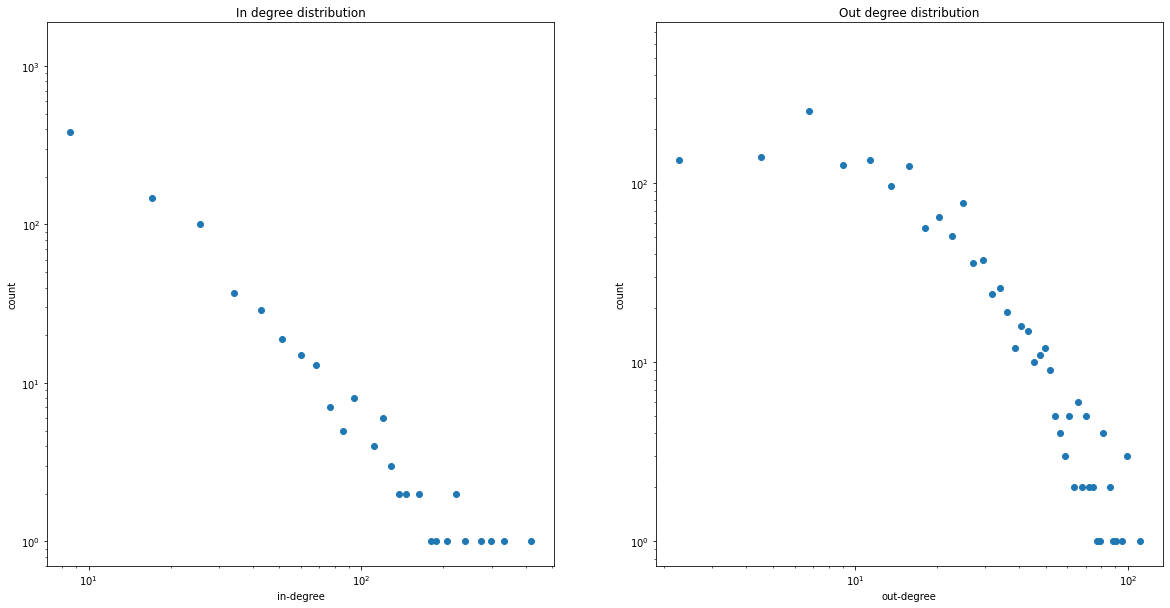

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
from scipy.optimize import curve_fit
h_in = np.histogram(properties['indegrees'],bins=50)
h_out = np.histogram(properties['outdegrees'],bins=50)
    

axes[0].loglog(h_in[1][:-1],h_in[0],'o')
axes[0].set_ylabel("count")
axes[0].set_xlabel("in-degree")
axes[0].set_title("In degree distribution")
axes[1].loglog(h_out[1][:-1],h_out[0],'o')
axes[1].set_ylabel("count")
axes[1].set_xlabel("out-degree")
axes[1].set_title("Out degree distribution")
print()

We can visualize the powerlaw fit, using the powerlaw package:

Text(0.5, 0, 'In-Degree')

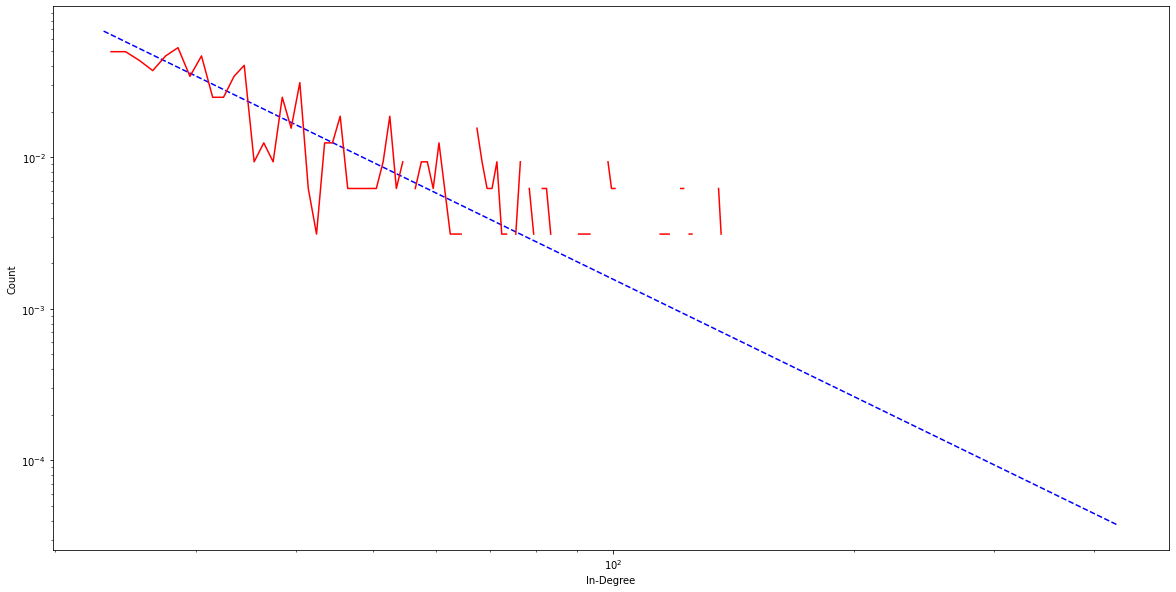

In [ ]:
PDF = fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf( color= 'r', linear_bins=True)
PDF.set_ylabel("Count")
PDF.set_xlabel("In-Degree")

**Plot the network using the Force Atlas algorithm as described in Lecture 5.**

In [ ]:
import fa2

In [ ]:
undirected = GCC.to_undirected()

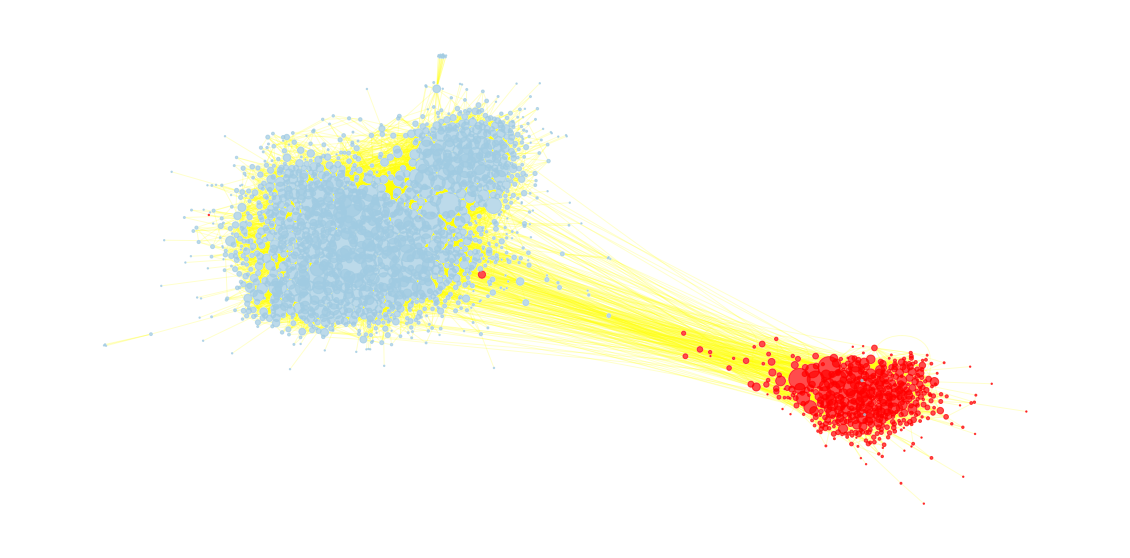

In [ ]:
d = dict(undirected.degree)
def fa_plot(graph,d,node_scale):
    color_map = []

    for n in graph.nodes:
        if 'attr' in graph.nodes[n]:
            t = graph.nodes[n]['attr']['team']
            if t == 'dc':
                color_map.append("#ff0000")
            elif t =='marvel':
                color_map.append("#A0CBE2")
        else:
            color_map.append("#000000")
            
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=500)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    nx.draw_networkx_nodes(graph, positions, node_size=[v * node_scale for v in d.values()], alpha=1, node_color='w')
    #Give the nodes their correct color
    nx.draw_networkx_nodes(graph, positions, node_color=color_map, node_size=[v * node_scale for v in d.values()], alpha=0.7)
    plt.axis('off')
    plt.show()
    
fa_plot(undirected,d,2)

We observe the red cluster which is made up of DC nodes, and the white/blue cluster made up of marvel nodes. 

The marvel nodes can be seen the split up into two sub-clusters.

We speculate that this happens because some marvel characters are tied together through the movies, While others are mostly tied through the comics.


# Communities 

**Identify the communities in one or both of the superhero universes (DC/Marvel).**

In [ ]:
#Create a new graph for dc and marvel respectively
dc_G = GCC.subgraph(formatted_dc_titles)
marvel_G= GCC.subgraph(formatted_marvel_titles)

marvel_UG = marvel_G.to_undirected()
dc_UG = dc_G.to_undirected()

In [ ]:
import networkx.algorithms.community as nx_com
import community

#Find the best partition for each universe - using the louvain algorithm
dc_partition = community.best_partition(dc_UG)
marvel_partition = community.best_partition(marvel_UG)

In [ ]:
dc_modularity = community.modularity(dc_partition, dc_UG)
marvel_modularity = community.modularity(marvel_partition, marvel_UG)
print("The modularity of the dc universe partition is", dc_modularity)
print("The modularity of the marvel universe partition is", marvel_modularity)

The modularity of the dc universe partition is 0.30319522489501305
The modularity of the marvel universe partition is 0.39778663393700603


In [ ]:
#For each node in the graphs, get the number of their community in the partition
dc_partition_values = [dc_partition.get(node) for node in dc_UG.nodes()]
marvel_partition_values = [marvel_partition.get(node) for node in marvel_UG.nodes()]

#Collect the values into a dictionary in order to get the number of communities and their sizes
dc_communities = {}
for key in dc_partition_values:
    if key in dc_communities:
        dc_communities[key] += 1
    else:
        dc_communities[key] = 1

marvel_communities = {}
for key in marvel_partition_values:
    if key in marvel_communities:
        marvel_communities[key] += 1
    else:
        marvel_communities[key] = 1
print("The dc network partition consists of", len(dc_communities), "communities and the sizes of the communities are", list(dc_communities.values()))
print("The marvel network partition consists of", len(marvel_communities), "communities and the sizes of the communities are", list(marvel_communities.values()))

The dc network partition consists of 10 communities and the sizes of the communities are [22, 113, 59, 68, 64, 59, 57, 28, 1, 1]
The marvel network partition consists of 13 communities and the sizes of the communities are [353, 11, 384, 118, 329, 332, 25, 4, 57, 19, 4, 1, 1]


#### Visualize the communities by coloring the graph's nodes according to community affiliation

In [ ]:
import matplotlib.colors as colors
def fa_community_plot(graph, partition):  
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=True,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=1000)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    #Count is used to give each community their own color
    count = 0
    #Go through each community and draw all the nodes in the same color
    for com in set(partition.values()) :
        count = count + 1
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        color = list(colors.cnames.keys())[count]
        nx.draw_networkx_nodes(graph, positions, list_nodes, node_size = 100, node_color = str(color), alpha=1)
    plt.axis('off')
    plt.show()

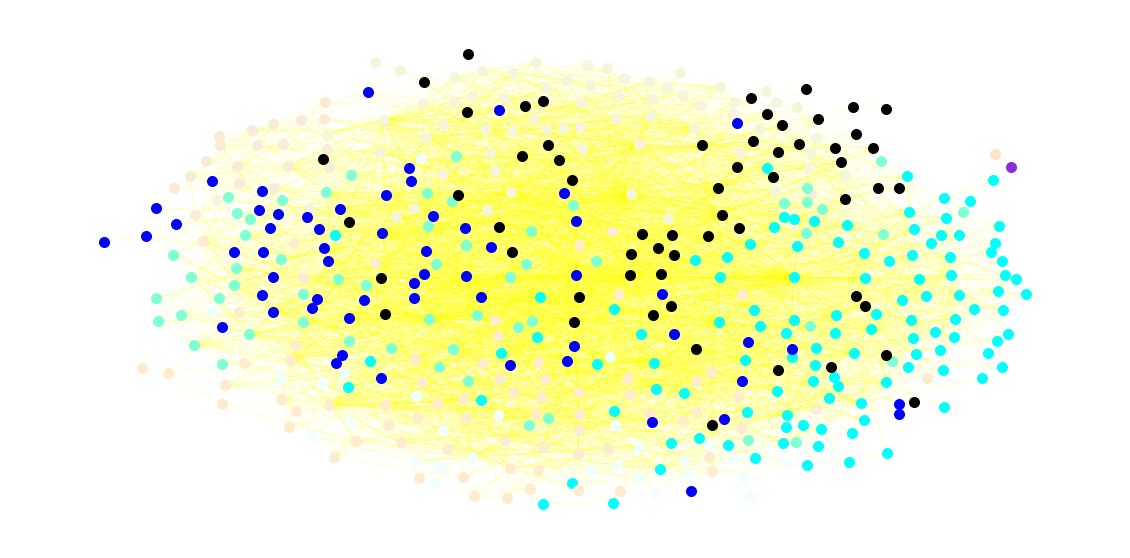

In [ ]:
fa_community_plot(dc_UG, dc_partition)

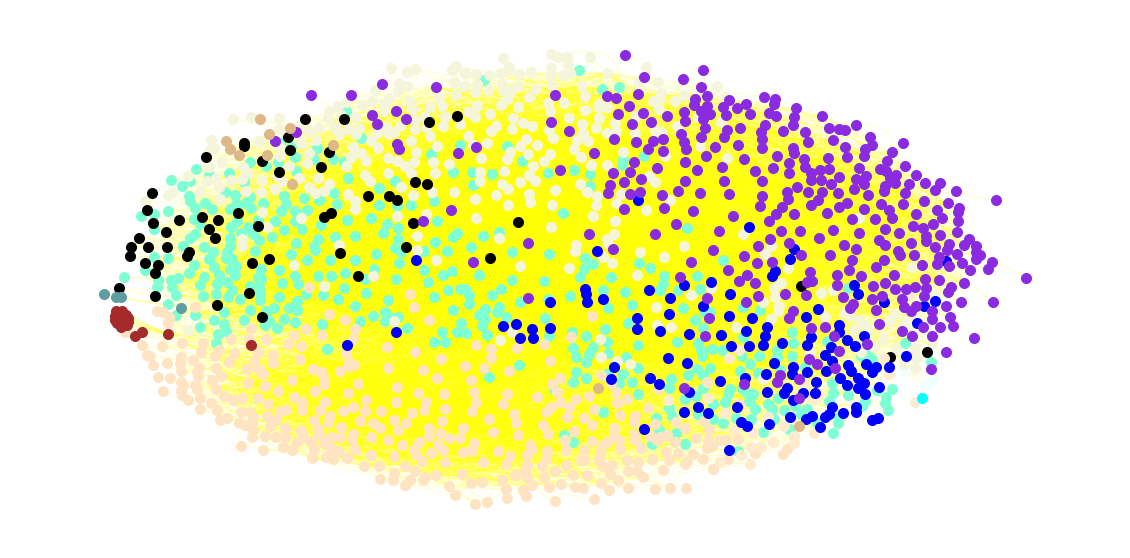

In [ ]:
fa_community_plot(marvel_UG, marvel_partition)

The resulting visualisation fits the expectations that there are going to be a few big communities consisting of most of the nodes of the networks, and then there are going to be a few very small communities - this is exactly what can be observed in both graphs. There are a few dominant colors representing the big communities. A small amount of nodes with less frequent occuring colors can be seen representing the communities of small sizes.

#### The louvain algorithm

In order to start identifying the communities of the two universes, they have to be isolated in the graph. This was done by creating two new graphs
using the networkx subgraph function. 

The louvain algorithm was used to create the most optimal partition of both networks.
The Louvain algorithm works by optimizing the modularity as the algorithm progresses. The first steps of the algorithm is to find small communities, this is done by letting every node be their own community - for each community, the modularity that can be gained by adding each of the neighbours in isolation is calculated. Only the neighbour yielding the highest modularity will join the community.  If no neighbour will increase the modularity then no new node is added to the community. The algorithm will keep doing this until there are no more nodes that can be moved into communities such that the modularity increases. When this happens the algorithm creates a new network. In this new network the nodes are the communities found from running the algorithm so far. The algorithm will then repeat the first step on the new graph. This process of adding neighbours to communities and creating new graphs to find bigger communities is done until no modularity gain can be achieved. 

#### The modularity

The concept of modularity can be explained as a measure of the strength of division of a network that consists of modules (communites). Modularity is used to detect community structures in a network. 

The modularity found for the networks can be seen above. The marvel universe has a higher modularity which indicates that it has a better partition than dc. A modularity of 0 means that the graph is one big community, while a modularity of 1 is the highest possible modularity a partion can have. The modularity can also be negative but it can not go lower than -0.5. If each node is its own community the modularity will become negative. With these numbers in mind it is clear that the partitions of both dc and marvel are good and that there are a clear sense of communities in the two networks.

#### The communities

There are a couple of communities in both networks that consists of just a single node, this is dragging the modularity score of both networks down. It makes sense that the marvel network has a better modularity than the dc network, because the communities are more connected in the marvel partition. Even though the marvel network has a lot more nodes than the dc network, there are only 3 more communities in the marvel partition. The marvel partition does have a lot of very small communities, which is dragging its modularity score down.

#### For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

TF-IDF stands for term frequency - inverse document frequency, where the term frequency is a measurement for how frequent a word appears in a document. 

The inverse document frequency is a weight to determine how rare or common a word is across multiple documents (corpus). 

The TF-IDF is therefore a way to measure the relevancy of the word to the document in a corpus, which is a way for us to cut out words that do not matter at all like stop words such as "the", as the TF-IDF can filter those words out, since their relevancy is lessening by a lot due to the IDF of the word. It will most likely appear in every text document. How the code of TF-IDF was made was by looking through the examples from the page: https://en.wikipedia.org/wiki/Tf%E2%80%93idf to understand it and write the code for it.

In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from collections import defaultdict
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import matplotlib.pyplot as plt


In [ ]:
## Add the partition values from previous part into a frequency distribution
DC_freq = nltk.FreqDist(dc_partition_values)

In [ ]:
# Lemmatization of lists
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemmatizeList(list):
    lemma_list = []
    for word, tag in pos_tag(list):
        lemma = WordNetLemmatizer().lemmatize(word, tag_map[tag[0]])
        lemma_list.append(lemma)
    return lemma_list


In [ ]:
## Text processing before doing TF-IDF
DC_path = "wikipages/dc/"

# This function takes the argument partition (communities), which has the information of the text files (key)
# and the value (the community number) given the path (DC or marvel). 
# What we get out of the function is a list of the community texts, where each text consist of all the texts from 
# each community
def text_processing(partition, community_list, path):

    corpus = []
    for i in community_list:
        text_files = [key for key, value in partition.items() if value == i]
        text = ""

        # Loop through all the text files and add it to a string called "text"
        for text_file in text_files:
            f = open(path+text_file+".txt","r")
            text = text + f.read() + " "

        # Only red text efter *, since that's where the text is within a wikipage
        try: 
            start = re.search('\*',text).span()[1]
        except AttributeError:
            print("Cannot read the txt file: " + text_file+".txt")

        # Remove all html elements that usually resides in websites in our string called "text"
        soup = BeautifulSoup(text, 'html.parser')

        # Remove all footnotes under the class "reference"
        for tag in soup.find_all(class_="reference"):
            tag.decompose()

        # Get the text after removing wiki and htlml elements
        raw = soup.get_text()
        tokens = word_tokenize(raw[start:])

        # Process each document of the text of a community through lemmatization, remove stop words and only take words/numbers.
        stop_words = stopwords.words('english')

        processed_text_1 = lemmatizeList([w.lower() for w in tokens if w.isalnum()])
        processed_text_2 = [w for w in processed_text_1 if not w in stop_words]
        corpus.append(processed_text_2)

    return corpus


We decided to only look at the 10 biggest communities within the DC universe

In [ ]:
# Extract the 10 largest communities (each community is defined by their number) and
# process the corpus which contains 10 documents of the 10 communities
DC_community_number_list = list(zip(*DC_freq.most_common(10)))[0] # Extract the most common occurences
DC_corpus = text_processing(dc_partition, DC_community_number_list, DC_path)

In [ ]:
# A list of all the tf list from each community
community_list_freq= []

for i, community_text in zip(DC_community_number_list, DC_corpus):
    
    # To have the term frequency in count
    term_freqdist = nltk.FreqDist(community_text)

    # To have the term frequency in count / N format, which is the tf-format of the example from the wikipage of TF-IDF
    total = term_freqdist.N()
    for word in term_freqdist:
        term_freqdist[word] /= float(total)
    
    # Add every term frequency distribution for a community in our list
    community_list_freq.append(term_freqdist)

    # Printing out the top 5 terms of each community (percentage)
    print("Community " + str(i) + " has these top 5 terms according to TF:")
    print(term_freqdist.most_common(5))

Community 1 has these top 5 terms according to TF:
[('comic', 0.020942835024243166), ('batman', 0.020906164690543128), ('dc', 0.012965000203724077), ('character', 0.010104714175121215), ('cite', 0.0070529275149737196)]
Community 7 has these top 5 terms according to TF:
[('comic', 0.02534694345681844), ('dc', 0.017502007110907214), ('character', 0.011079252207821999), ('justice', 0.008020797492067133), ('category', 0.007286768360285966)]
Community 4 has these top 5 terms according to TF:
[('superman', 0.02694793560631196), ('comic', 0.02146677460882029), ('dc', 0.011247660884683274), ('character', 0.008785783487504811), ('lois', 0.006675602861351842)]
Community 6 has these top 5 terms according to TF:
[('comic', 0.020049766384418466), ('lantern', 0.019056228853762017), ('green', 0.014553982205832334), ('dc', 0.014142245931866597), ('character', 0.008189971536492365)]
Community 8 has these top 5 terms according to TF:
[('comic', 0.023227873448137766), ('dc', 0.015283456426781906), ('flas

In [ ]:
# In this code section, we want to calculate the IDF of every word from the whole DC_corpus
idf_list = []
# Extract all words from the whole DC_corpus
DC_words = [item for document in DC_corpus for item in document]

# Check amount of occurence of a word
for word in set(DC_words):
    occurences = 0

    # Check if the word occurs on each community text. Max occurence is the total amount of text documents of the corpus
    for community_text in DC_corpus:
        if word in community_text:
            occurences += 1
    
    # Calculate the inverse document frequency
    idf = np.log(len(DC_corpus)/occurences)
    idf_list.append((word,idf))

# Convert the list of tuples to a dictionary, which we will use later
idf_dict = dict(idf_list)
    

In [ ]:
# A list of all the tf-idf list from each community
community_list_tf_idf = []

for term_freqdist in community_list_freq:
    community_tf_idf = nltk.FreqDist(term_freqdist) # Copies values and ensures that we don't overwrite tf distribution

    for word in community_tf_idf:

        # Get the idf of the word from the idf dictionary we made previously
        idf = idf_dict[word]

        # tf-idf is calculated by the tf of a word within the document and the idf of the word of the document set (our corpus)
        community_tf_idf[word] = (dict(term_freqdist)[word] * idf)

    community_list_tf_idf.append(community_tf_idf)

In [ ]:
# Listing the 10 top words for each community accourding to TF-IDF
for i, tf_idf in zip(DC_community_number_list,community_list_tf_idf):
    print("The top 10 term according to TF-IDF for community " + str(i) + ":")
    print(tf_idf.most_common(10))

The top 10 term according to TF-IDF for community 1:
[('batman', 0.004665075833407531), ('anarky', 0.0030303344539668207), ('cite', 0.0015738152928529401), ('selina', 0.0013246402571474075), ('appear', 0.0012974202327562944), ('shiva', 0.001250919060844696), ('harley', 0.0012175894955918371), ('bane', 0.0011861704593373957), ('new', 0.001093760714790345), ('character', 0.0010646378960657186)]
The top 10 term according to TF-IDF for community 7:
[('abby', 0.0019014351037455132), ('lucifer', 0.0018963825950311032), ('justice', 0.0017897892367519674), ('amethyst', 0.001612083698657087), ('shazam', 0.0015708587965646663), ('freddy', 0.0015557701871857109), ('cite', 0.0015372736914332913), ('isi', 0.0014176840758970382), ('league', 0.0013956602437207905), ('appear', 0.001346180846327266)]
The top 10 term according to TF-IDF for community 4:
[('superman', 0.006013258051779094), ('lois', 0.00238102027632991), ('lara', 0.002123845889966505), ('lionel', 0.0017087822399066744), ('brainiac', 0.00

#### Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

In [ ]:
# Function to make wordclouds with titles
from wordcloud import WordCloud
def make_word_cloud(tf_idf, community_number):

    # To make this work check: https://stackoverflow.com/questions/47298070/importerror-no-module-named-wordcloud
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(tf_idf) 
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Community " + str(community_number))
    plt.show()

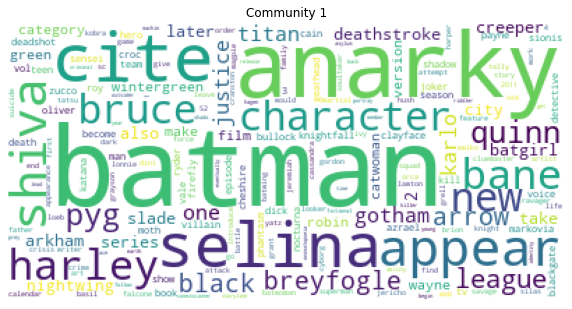

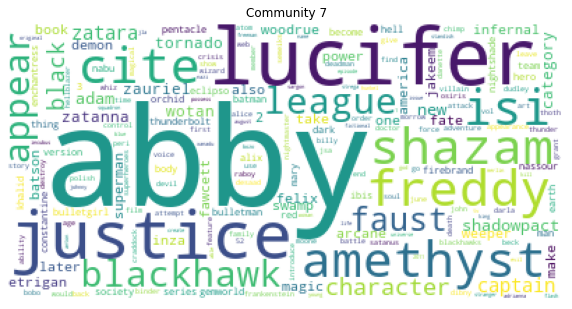

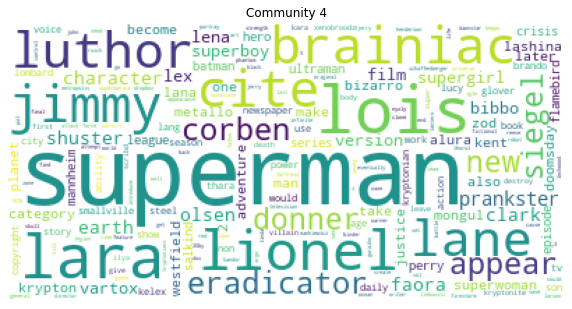

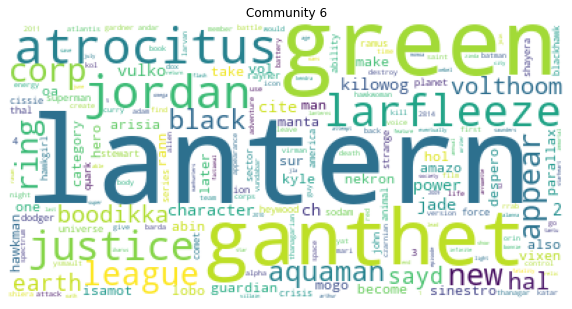

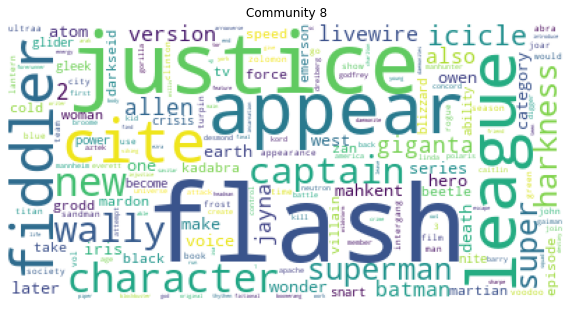

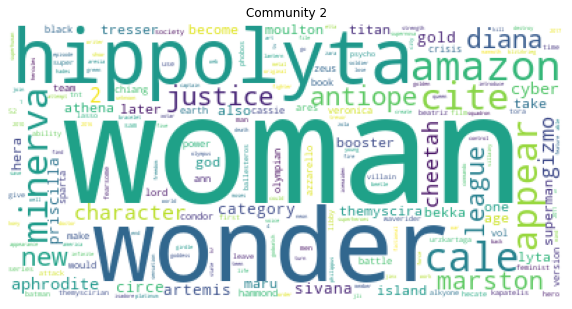

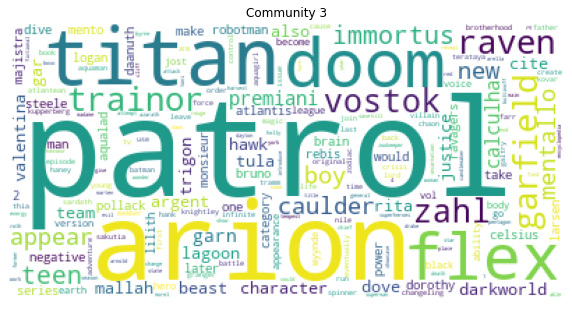

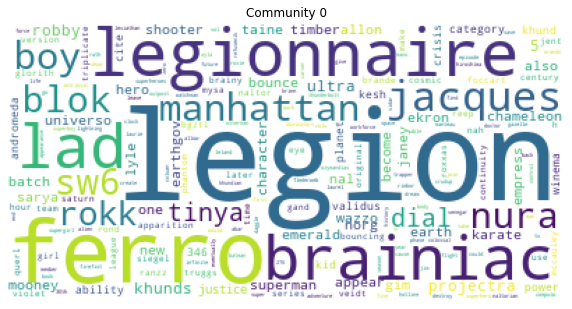

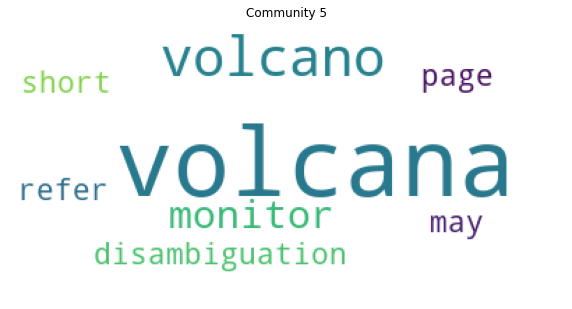

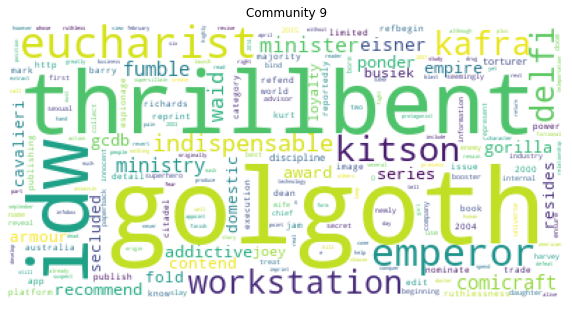

In [ ]:
# Create word clouds for each DC community
for i, tf_idf in zip(DC_community_number_list,community_list_tf_idf):
    make_word_cloud(dict(tf_idf),i)

The only figure captions that make sense to have in word clouds are the tiles of which community each word cloud is a part of. The word clouds based of the TF-IDF, which filters the not so relevant words out, are ordered after their size of community, which means the biggest community of the DC universe is the one that has batman, selina and anarky, which are some notable characters. selina is catwoman, who has crossed paths with batman in many occasions and anarky is a supervillain that appears in the DC universe as an antagonist of batman. The further down we look through the word clouds the more less known characters or stuff from the DC universe, it seems like. The word clouds also tells us what/who plays major role in each community, since the more they are mentioned in their respective community the larger the text is within the word cloud. It also gives an understanding that superman and batman are within their own respective communities, so they don't have that much of a connection with each other within the DC universe. 

In [ ]:
community_list_tf_idf[0]

FreqDist({'batman': 0.004665075833407531, 'anarky': 0.0030303344539668207, 'cite': 0.0015738152928529401, 'selina': 0.0013246402571474075, 'appear': 0.0012974202327562944, 'shiva': 0.001250919060844696, 'harley': 0.0012175894955918371, 'bane': 0.0011861704593373957, 'new': 0.001093760714790345, 'character': 0.0010646378960657186, ...})

In [ ]:
community_list_freq[0]

FreqDist({'comic': 0.020942835024243166, 'batman': 0.020906164690543128, 'dc': 0.012965000203724077, 'character': 0.010104714175121215, 'cite': 0.0070529275149737196, 'series': 0.006409159434461965, 'category': 0.006115796764861671, 'appear': 0.0058142851322169255, 'new': 0.004901601271238235, 'vol': 0.0046775047875157886, ...})

# Sentiment

We start by creating a dictionary of our tokens, which we will need down the line

In [ ]:
from nltk.corpus import PlaintextCorpusReader
#The root is the directory
corpus_root_dc = r"wikipages/dc" 
corpus_root_marvel = r"wikipages/marvel"
file_pattern = r".*\.txt"
ptb_dc = PlaintextCorpusReader(corpus_root_dc, file_pattern)
ptb_marvel = PlaintextCorpusReader(corpus_root_marvel, file_pattern)
xx = 0
token_dict = {}
for fileid in ptb_dc.fileids():
    html = ptb_dc.raw(fileids=fileid)
    raw = BeautifulSoup(html, 'html.parser').get_text()
    try: 
        start = re.search('\*',raw).span()[1]
    except AttributeError:
        xx = xx+1
    tokens = word_tokenize(raw[start:])
    token_dict[fileid.split('.txt')[0]] = [w.lower() for w in tokens if w.isalpha()]

for fileid in ptb_marvel.fileids():
    html = ptb_marvel.raw(fileids=fileid)
    raw = BeautifulSoup(html, 'html.parser').get_text()
    try: 
        start = re.search('\*',raw).span()[1]
    except AttributeError:
        xx = xx+1
    tokens = word_tokenize(raw[start:])
    token_dict[fileid.split('.txt')[0]] = [w.lower() for w in tokens if w.isalpha()]
stop_words = stopwords.words('english')

for k,v in token_dict.items(): #remove stop words from token_dict for later sentiment use
    token_dict[k] = [w for w in v if w not in stop_words]

C:\Users\Marc\AppData\Roaming\Python\Python39\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


First we load the dataset into a python dictionary, where we define each word as a Word object, containing all the information for that word from the data set.

In [ ]:
class Word:
    def __init__(self,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank):
        self.word = word
        #self.happiness_rank = float(happiness_rank)
        self.happiness_average = float(happiness_average)
        #self.happiness_standard_deviation = float(happiness_standard_deviation)
        #self.twitter_rank = twitter_rank
        #self.google_rank = google_rank
        #self.nyt_rank = nyt_rank
        #self.lyrics_rank = lyrics_rank

labMIT = {}
with open("labMIT.txt") as f:
    for line in f:
       (word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank) = line.split()
       labMIT[word] = Word(word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank)


We only really use the happiness_average stat to calculate the sentiment.

In [ ]:
def get_sentiment(tokenlist):
    sentiment = 0
    num_of_tokens = len(tokenlist)
    if num_of_tokens == 0:
        print('input tokenlist was empty')
        num_of_tokens = 1
    
    for w in tokenlist:
        try: 
            sentiment = sentiment + (labMIT[str(w)].happiness_average)
        except KeyError:
            if num_of_tokens > 1:
                num_of_tokens = num_of_tokens-1
                
    sentiment = sentiment/num_of_tokens
    return sentiment

**First calculate the sentiment for all character pages.**

Since we already tokenized the pages earlier in this notebook, we simply access the tokenlists associated with each page, when needed.

In [ ]:
fails = 0
sentiments = []
for n in GCC.nodes:
    try:
        s = get_sentiment(token_dict[str(n)])
        GCC.nodes[n]['Sentiment'] = s
        if s != 0: #We dont consider pages with sentiment 0, as these contain no words in our sentiment library.
            sentiments.append(s)
    except KeyError:
        fails = fails + 1

#print(fails,"nodes could not have their sentiment calculated")

input tokenlist was empty


**Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment.**

**Create a histogram of all character's associated page-sentiments.**

The following code (functions: outlier_aware_sentiment_hist, mad, calculate) is a modified version of the code posted by user Benjamin Doughty in the stackoverflow thread [Making pyplot.hist() first and last bins include outliers](https://stackoverflow.com/questions/15837810/making-pyplot-hist-first-and-last-bins-include-outliers)

In [ ]:
def outlier_aware_sentiment_hist(data,mean,tenth,ninetieth,t,sent=False,lower=None, upper=None):
    if not lower or lower < min(data):
        lower = min(data)
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > max(data):
        upper = max(data)
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto',edgecolor='black')

    if lower_outliers:
        n_lower_outliers = sum(data < lower)
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower))

    if upper_outliers:
        n_upper_outliers = sum(data > upper)
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data)))
    if sent:
        plt.plot([mean,mean],[0,max(n)*1.02],linewidth=5)
        plt.plot([tenth,tenth],[0,max(n)*1.02],linewidth=5)
        plt.plot([ninetieth,ninetieth],[0,max(n)*1.02],linewidth=5)
        plt.legend(['Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower),('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data))),('Distribution Mean: {:.2f}'.format(mean)),('10th percentile: {:.2f}'.format(tenth)),'90th percentile: {:.2f}'.format(ninetieth)])
        plt.xlabel('Sentiment value')
        plt.ylabel('Count')
    else:
        plt.legend()
    plt.title(t)
        
    
def mad(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    return mad

def calculate_bounds(data, z_thresh=3.5):
    MAD = mad(data)
    median = np.median(data)
    const = z_thresh * MAD / 0.6745
    return (median - const, median + const)

We now make a generalized function that can be used to calculate the stats and plot for any given sentiment.

Sentiment mean: 5.579421655057277
tenth percentile: 5.3933333333333335
ninetieth percentile: 5.791662093862806


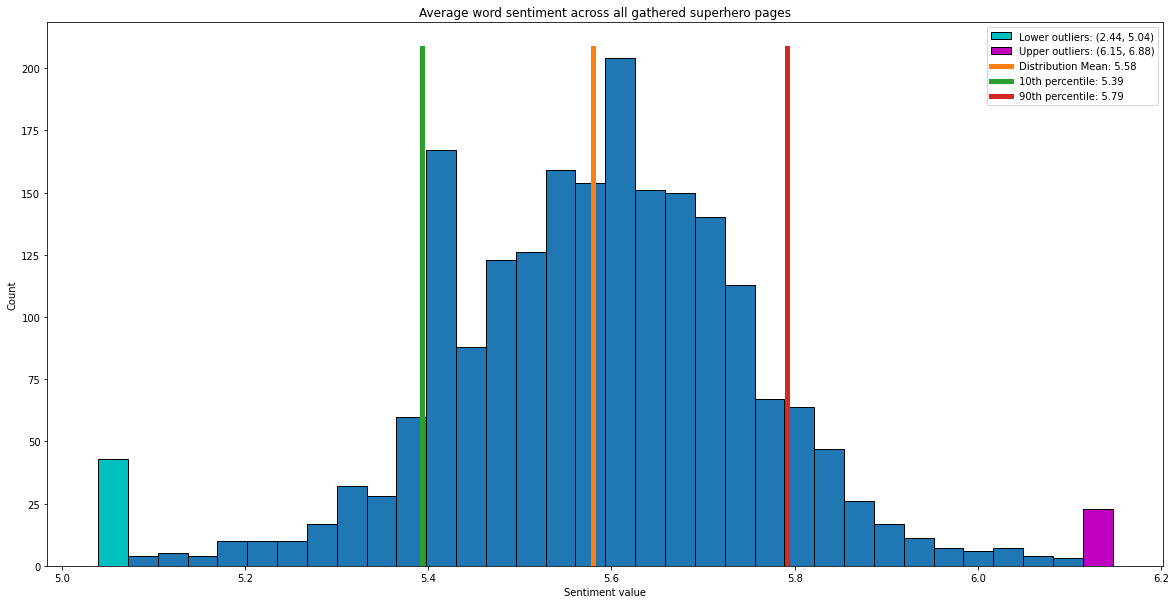

In [ ]:
def sentiment_stats_and_hist(sents,t):
    sent_mean = mean(sents)
    tenth = np.percentile(sents,10)
    ninetieth = np.percentile(sents,90)
    print("Sentiment mean:",sent_mean)
    print("tenth percentile:",tenth)
    print("ninetieth percentile:",ninetieth)
    outlier_aware_sentiment_hist(sents,sent_mean,tenth,ninetieth,t,True,*calculate_bounds(sents))

sentiment_stats_and_hist(sentiments,'Average word sentiment across all gathered superhero pages')

According to [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s2) a score of around 5 is where neutral words such as "the" ranked, and thus this is not an odd result, even though we removed stop words, it is not unthinkable that large pages such as  wikipages would naturally average out to a neutral sentiment. Furthermore wikipedia pages are often written in a neutral language. 

**Now grab the good/bad character names.**

A quick glance at the good/bad character file reveals that some characters are characterized as being neither bad nor good. We choose to ignore these, as the assignemnt specifically asks for good/bad characters.

In [ ]:
good_chars = []
bad_chars = []
temp_links = []
fails = 0
with open("nature.txt") as f:
    for line in f:
        try:
            (idx,CharacterName,WikiLink,universe,woman,man,good,bad) = line.split(',')
            temp_links = cv_splitter(WikiLink)
            for l in temp_links:
                if int(good):
                    good_chars.append(string_formatter(l))
                if int(bad):
                    bad_chars.append(string_formatter(l))
        except ValueError:
            fails = fails + 1
print(fails,"out of",idx,"lines failed to parse and have been ignored")        

21 out of 2302 lines failed to parse and have been ignored


**Calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.**

First we calculate the sentiment distributions for good and bad characters.

In [ ]:
good_char_sentiments = []
bad_char_sentiments = []
for c in good_chars:
    s = get_sentiment(token_dict[c])
    if s != 0:
        bad_char_sentiments.append(s)

for c in bad_chars:
    s = get_sentiment(token_dict[c])
    if s != 0:
        good_char_sentiments.append(s)
    

Now we examine the distributions

Good character sentiments stats:
Sentiment mean: 5.539864111180089
tenth percentile: 5.39583082955145
ninetieth percentile: 5.7


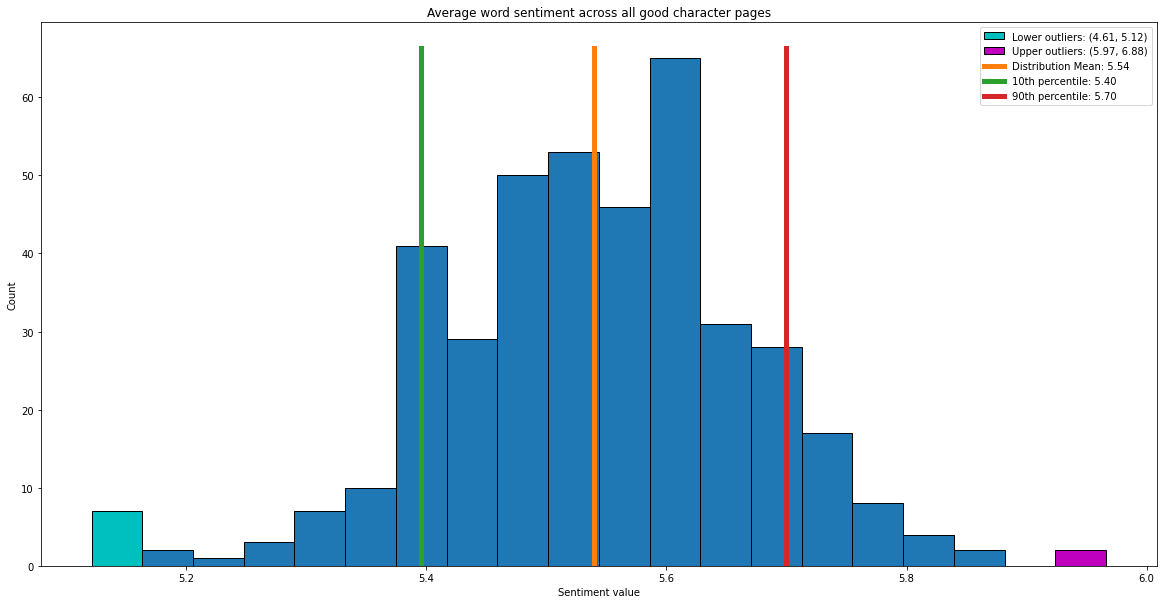

In [ ]:
print("Good character sentiments stats:")
sentiment_stats_and_hist(good_char_sentiments,'Average word sentiment across all good character pages')

Bad character sentiments stats:
Sentiment mean: 5.623811718879603
tenth percentile: 5.3999999999999995
ninetieth percentile: 5.793265060240965


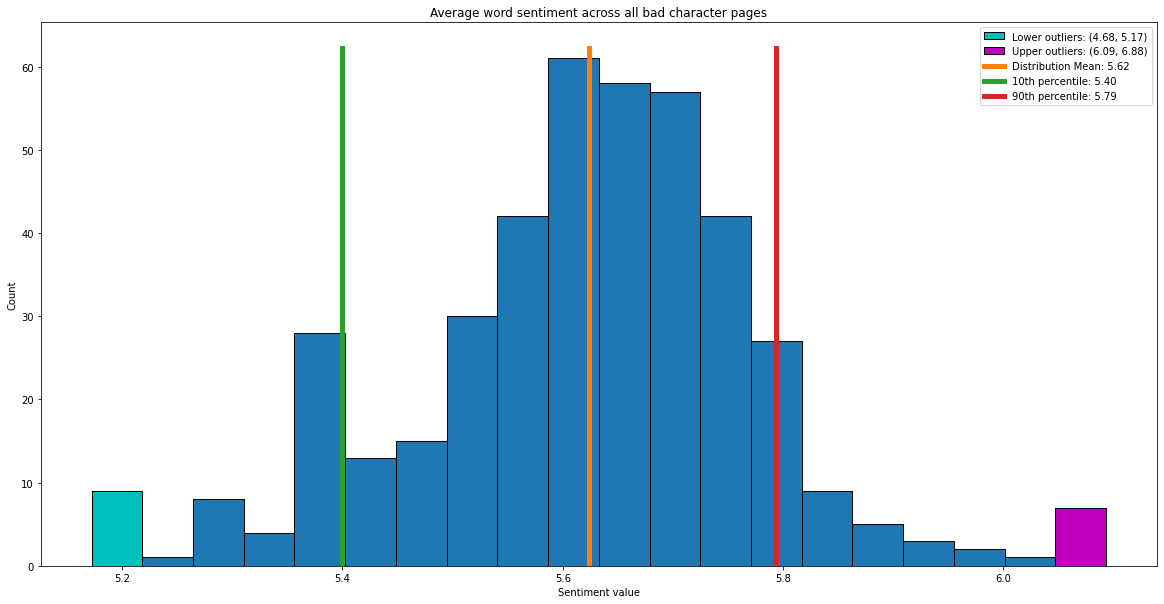

In [ ]:
print("Bad character sentiments stats:")
sentiment_stats_and_hist(bad_char_sentiments,'Average word sentiment across all bad character pages')

Oddly enough, the bad character pages seem to have a slightly higher average sentiment value than the good character pages. We attribute this to the previously mentioned fact, that wikipedia pages are often written in neutral language, and thus it is a coincidence that the bad characters are have a slightly higher sentiment than the good characters

**Finally use the label permutation test (see Week 5) to investigate the two hypotheses below**

**H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.**   

**H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.**

In [ ]:
import random
def check_hypothesis_permutation_test(hypothesis):
    set_size = 100
    repetitions = 1000
    holds = 0

    if hypothesis == "H1":
        test_sentiments = good_char_sentiments
    elif hypothesis == "H2":
        test_sentiments = bad_char_sentiments
        
    
    for j in range(repetitions):
        test_sent = 0
        random_sent = 0
        
        for i in range(set_size):
            test_sent = test_sent + random.choice(test_sentiments)
            random_sent = random_sent + random.choice(bad_char_sentiments + good_char_sentiments)
            
        test_avg = test_sent/set_size
        random_avg = random_sent/set_size
        
        if hypothesis == "H1":
            if test_avg > random_avg:
                holds = holds + 1
        elif hypothesis == "H2":
            if test_avg < random_avg:
                holds = holds + 1
                
                
    if hypothesis == "H1":   
        print("Hypothesis H1 holds",holds,"out of",repetitions,"times, using a set size of",set_size)
    elif hypothesis == "H2":   
        print("Hypothesis H2 holds",holds,"out of",repetitions,"times, using a set size of",set_size)

check_hypothesis_permutation_test("H1")
check_hypothesis_permutation_test("H2")

Hypothesis H1 holds 41 out of 1000 times, using a set size of 100
Hypothesis H2 holds 68 out of 1000 times, using a set size of 100


Neither of the hypothesis seem to hold, in fact the opposite of both hypothesis seems to be the case.
This could either be due to some error in the way sentiment was calculated, or an error in how the token lists were generated.

It should however be noted, as we saw on the distribution plots, that the difference in mean sentiment value between the bad and the good characters is very small. Since wikipages are naturally written in a neutral describing language, the chosen words will often be ones that are associated with a neutral happiness value. However, if it was the case that all the pages were perfectly neutral, we would expect the hypothesis to hold approximately half the time.

This is not the case. We speculate that the bad character pages often describe how the good characters overcome the bad characters, rather than focusing on the evil deeds of the good characters, and therefore this might push them in the direction of a higher average sentiment.